In [21]:
# first test for polyphonic music
import librosa
import numpy as np
import os
from sporco.admm import cbpdn
import sporco.metric as sm
import pickle 
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelextrema
import scipy.io.wavfile
sr = 11025

In [22]:
# load the dictionary
D = []
directory = './maps/notes/'

for i in range(21,109):
    fname1 = 'MAPS_ISOL_NO_F_S0_M' + str(i) + '_SptkBGCl.wav'
    fname2 = 'MAPS_ISOL_NO_F_S1_M' + str(i) + '_SptkBGCl.wav'
    
    try:
        s = librosa.load(directory + fname1, sr=11025,offset=0.7,duration=1.0)[0]
    except:
        s = librosa.load(directory + fname2, sr=11025,offset=0.7,duration=1.0)[0]
    # normalize dictionary elements
    D.append(s/np.amax(s))
    
D = np.asarray(D)
D = D.T

with open('mapsdict.pkl','wb') as fid:
     pickle.dump(D,fid)

In [23]:
#solve the CBPDN problem
with open('mapsdict.pkl','rb') as fid:
    D = pickle.load(fid)
print(D.shape)
lmbda = 0.005
# 1 temporal dimension
dimN = 1

opt = cbpdn.ConvBPDN.Options({'Verbose' : True, 'MaxMainIter' : 500,
                    'HighMemSolve' : True, 'LinSolveCheck' : True,
                    'RelStopTol' : 1e-3, 'AuxVarObj' : False})

songdir = "./maps/songs/"
songname = "MAPS_MUS-alb_esp2_SptkBGCl.wav"
song, sr = librosa.load(songdir+songname,sr=sr,duration=5.0)

b = cbpdn.ConvBPDN(D, song, lmbda, opt,dimN=dimN)
X = b.solve()
X = X[:,0,0,:]
with open('maps_results_esp2.pkl', 'wb') as fid:
    pickle.dump(X, fid)

(11025, 88)
Itn   Fnc       DFid      Regℓ1     r         s         ρ         
----------------------------------------------------------------
   0  4.80e-01  4.10e-01  1.41e+01  1.00e+00  0.00e+00  1.25e+00
   1  5.18e-01  4.47e-01  1.41e+01  1.00e+00  0.00e+00  1.25e+00
   2  6.77e-02  3.58e-03  1.28e+01  3.93e-01  2.20e+00  1.25e+03
   3  1.02e-01  1.69e-03  2.01e+01  4.84e-01  6.92e-01  5.23e+02
   4  8.46e-02  1.04e-03  1.67e+01  4.34e-01  4.67e-01  4.32e+02
   5  6.93e-02  1.11e-03  1.36e+01  3.39e-01  2.86e-01  4.32e+02
   6  6.11e-02  1.07e-03  1.20e+01  2.44e-01  2.50e-01  4.32e+02
   7  5.54e-02  9.58e-04  1.09e+01  1.90e-01  2.04e-01  4.32e+02
   8  4.80e-02  9.00e-04  9.42e+00  1.52e-01  1.91e-01  4.32e+02
   9  4.48e-02  8.99e-04  8.79e+00  1.36e-01  1.58e-01  3.81e+02
  10  4.09e-02  9.09e-04  8.00e+00  1.07e-01  1.42e-01  3.81e+02
  11  4.01e-02  8.97e-04  7.85e+00  9.74e-02  1.30e-01  3.26e+02
  12  3.89e-02  8.74e-04  7.61e+00  9.02e-02  1.15e-01  2.79e+02
  13  3.77e

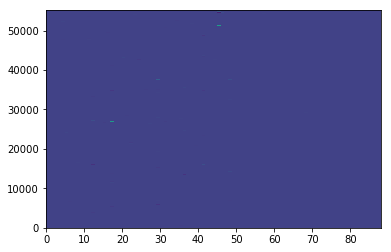

In [24]:
with open('maps_results_esp2.pkl','rb') as Y:
    Y = pickle.load(Y)
plt.pcolormesh(Y)

In [38]:
with open('maps_results_esp2.pkl','rb') as Y:
    Y = pickle.load(Y)
    
duration = song.shape[0]/sr

lmaxes = np.asarray([])
for row in Y:
    relex = argrelextrema(row,np.greater)[0]
    lmaxes = np.concatenate((lmaxes,row[relex]))

p75,p25 = np.percentile(lmaxes, [75,25])
# try different values for iqr
threshold = p75 + 12*(p75-p25)
# lmaxes = np.sort(lmaxes)
# l = lmaxes.shape[0]
# threshold = lmaxes[95*int(l/100)]
# need to select proper threshold value
print('threshold is', threshold)
# new array of only below threshold
lowvals = Y < threshold
Y[lowvals] = 0

#duration of each window
window_size = 0.05
start = 0
l = int(sr*window_size)
end = l
window = 0
print('finding maxima')
potential_notes = np.asarray([])



for i in range(int(duration/window_size)):
    row = Y[start:end,:]
    #print(row.shape)
    sumrow = np.sum(row,axis=0)
    relex = argrelextrema(sumrow,np.greater)[0]
    if(len(relex) != 0):
        t = window_size * window
        print(relex+21, t)
        print('\n')
    start = end
    end += l
    window+=1


threshold is 0.00183084793389
finding maxima
[38] 0.45


[38 50] 0.5


[57] 1.2000000000000002


[66] 1.4000000000000001


[50 62 66 69 81] 1.4500000000000002


[33 45] 1.9000000000000001


[38] 2.4000000000000004


[38 50] 2.45


[50] 2.5


[57] 3.1500000000000004


[50 62 66 81] 3.4000000000000004


[33 45] 3.85


[50 62 66] 4.3500000000000005


[50] 4.4


[66] 4.65


[66] 4.9


[66] 4.95




In [ ]:
# peak is OK if it occurs within [onset - 0.05, offset+0.05]
